## 회귀(Regression)
### ex) 주택 가격 예측하기
- 보스턴 외곽 지역 범죄율, 지방세율 등 데이터를 이용해 주택 가격의 중간값 예측
- 참고 : https://github.com/gilbutITbook/006975/blob/master/3.6-predicting-house-prices.ipynb

- <b>Boston housing 데이터셋</b> :<br>
각 특성(feature)의 스케일이 서로 다른 입력 데이터로 주택 가격 예측할 수 있는 데이터

### 1. 데이터셋 로드

In [1]:
from keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

57026/57026 [==============================] - 0s 5us/step


In [3]:
print(train_data.shape, test_data.shape)

# 13개의 수치 특성이 있음

(404, 13) (102, 13)


1) Per capita crime rate(1인당 범죄율).
2) Proportion of residential land zoned for lots over 25,000 square feet(25,000평방피트 이상의 부지로 구획된 주거용 토지의 비율).
3) Proportion of non-retail business acres per town(도시당 비소매업 에이커의 비율).
4) Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)(Charles River 더미 변수(= 지역이 강 경계이면 1, 그렇지 않으면 0)).
5) Nitric oxides concentration (parts per 10 million)(산화질소 농도(1000만분의 1)).
6) Average number of rooms per dwelling(가구당 평균 방 수).
7) Proportion of owner-occupied units built prior to 1940(1940년 이전에 건축된 소유주가 차지하는 비율).
8) Weighted distances to five Boston employment centres(5개의 보스턴 고용 센터까지의 가중 거리).
9) Index of accessibility to radial highways(방사형 고속도로 접근성 지수).
10) Full-value property-tax rate per $10,000($10,000당 전체 가치 재산세율).
11) Pupil-teacher ratio by town(도시별 학생-교사 비율).
12) 1000 * (Bk - 0.63) ** 2 where Bk is the proportion of Black people by town(1000 * (Bk - 0.63) ** 2 여기서 Bk는 도시별 흑인 비율입니다).
13) % lower status of the population(인구의 % 낮은 지위).

### 2. 데이터 준비
상이한 스케일을 가진 값을 신경망에 주입하게 되면 학습을 어렵게 만들게 된다. 
<br> 특성의 스케일이 다르면 전역 최소점을 찾아가는 경사하강법 경로가 스케일이 큰 특성의 영향을 많이 받는다.
<br> 이런 경우에는 특성별로 표준화(정규화)가 필요하다. 표준화는 입력데이터에 있는 각 특성에 대해 특성의 평균을 빼고 표준편차로 나누면 된다.

In [5]:
# 데이터 표준화
mean = train_data.mean(axis=0)
std = train_data.std(axis=0)
scaled_train_data = (train_data - mean)/std

### 3. 모델 구성

In [7]:
scaled_train_data.shape

(404, 13)

In [10]:
from keras import models
from keras import layers

# 모델 함수화
def build_model() : 
    # 모델 생성
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', 
                           input_shape=(scaled_train_data.shape[1], )))  # 특성 개수
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    
    # 모델 컴파일
    model.compile(optimizer='rmsprop', 
                  loss='mse', 
                  metrics=['mae'])
    return model

스칼라 회귀(하나의 연속적 값 예측)를 위한 구성으로 마지막 층(선형층)은 하나의 유닛을 가지고 활성화함수가 없다. <br>
활성화함수를 적용하면 출력값 범위를 제한하게 되기 때문에 선형 네트워크에서는 어떤 범위값이라도 자유롭게 학습된다.<br>
회귀의 손실함수는 예측과 타깃 사이 거리의 제곱인 평균제곱오차(mean squared error)를 사용하며, <br>
모니터링은 예측과 타깃 사이 거리의 절댓값인 평균절대오차(mean absolute error)를 측정한다.
- 회귀 손실함수 : mse
- 회귀 모니터링 지표 : mae

### 4. 훈련 검증(k-겹 검증)

우리는 훈련에 사용하는 매개변수들(에포크수 등)을 조정하면서 모델을 평가하기 위해 데이터를 훈련/검증셋으로 나눈다.<br>
데이터가 적은 경우는 나누면 더 작아지므로 신뢰있는 모델 평가를 할 수 없다. 이런 경우 K-겹 교차검증(k-fold cross-validation)을 사용한다.<br>
<br> 데이터를 k개 분할(폴드)로 나누고 k개의 모델을 각각 만들어 k-1개 분할에서 훈련하고 나머지 분할에서 평가하는 방법으로
<br>검증 점수는 k개 검증 점수 평균이다.
<br><br><img src = 'https://thebook.io/img/006975/130.jpg' width ='60%' height='60%'/>

##### 에포크 = 100

In [17]:
# k-겹 교차검증
import numpy as np

k = 4
num_val_samples = len(scaled_train_data) // k
num_epochs = 100
all_scores = []

for i in range(k) :
    print('처리중인 폴드 #', i)
    val_data = scaled_train_data[i*num_val_samples : (i+1)*num_val_samples]
    val_targets = train_targets[i*num_val_samples : (i+1)*num_val_samples]
    
    partial_train_data = np.concatenate(
        [scaled_train_data[ : i*num_val_samples],
         scaled_train_data[(i+1)*num_val_samples : ]], axis = 0)
    partial_train_targets = np.concatenate(
        [train_targets[ : i*num_val_samples],
         train_targets[(i+1)*num_val_samples : ]], axis = 0)
    
    model = build_model()   # 위에서 생성한 모델 함수
    model.fit(partial_train_data, 
              partial_train_targets,
              epochs = num_epochs,
              batch_size = 1,
              verbose = 0)  # verbose = 0 : 훈련과정 출력하지 않음
    
    # 검증 세트로 모델 평가
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose = 0)
    all_scores.append(val_mae)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


In [24]:
all_scores # 폴드별 검증 점수

[2.0823559761047363, 2.590374231338501, 2.5613133907318115, 2.561105489730835]

In [25]:
np.mean(all_scores) # 최종 점수

2.448787271976471

검증셋이 달라 검증점수의 변화가 2.0에서 2.7까지 크게 나타난다. 평균값(2.5)이 각각의 점수보다 신뢰할 만한 점수다.

##### 에포크 = 500

In [26]:
from keras import backend as K

# 메모리 해제
K.clear_session()

In [29]:
# k-겹 교차검증
import numpy as np

k = 4
num_val_samples = len(scaled_train_data) // k
numnum_epochshs = 500
all_mae_histories = []

for i in range(k) :
    print('처리중인 폴드 #', i)
    val_data = scaled_train_data[i*num_val_samples : (i+1)*num_val_samples]
    val_targets = train_targets[i*num_val_samples : (i+1)*num_val_samples]
    
    partial_train_data = np.concatenate(
        [scaled_train_data[ : i*num_val_samples],
         scaled_train_data[(i+1)*num_val_samples : ]], axis = 0)
    partial_train_targets = np.concatenate(
        [train_targets[ : i*num_val_samples],
         train_targets[(i+1)*num_val_samples : ]], axis = 0)
    
    model = build_model()   # 위에서 생성한 모델 함수
    history = model.fit(partial_train_data, 
                        partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs = num_epochs,
                        batch_size = 1,
                        verbose = 0)  # verbose = 0 : 훈련과정 출력하지 않음
    print(history.history.keys())
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

처리중인 폴드 # 0
dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])
처리중인 폴드 # 1
dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])
처리중인 폴드 # 2
dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])
처리중인 폴드 # 3
dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


In [32]:
# k-겹 검증 점수 평균 기록
average_mae_history = [
    np.mean([ x[i] for x in all_mae_histories]) for i in range(num_epochs) ]

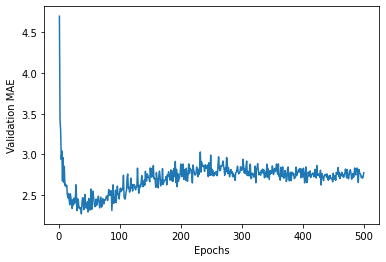

In [33]:
# 검증 점수 그래프
import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

해당 그래프는 변동이 심하고 보기 어려우므로 범위 차이가 많이 나는 첫 10개 데이터를 제외시키고<br>
부드러운 곡선을 얻기 위해 지수이동평균을 활용.
- 지수이동평균 : 시계열 데이터를 부드럽게 만드는 기법<br>(이전에 계산된 이동평균 x factor) + (현재 포인트 x (1-factor))

In [40]:
# 처음 10개 데이터 제외한 검증 점수 그래프

# 지수이동평균 함수
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# 검증점수의 지수이동평균화
smooth_mae_history = smooth_curve(average_mae_history[10:])

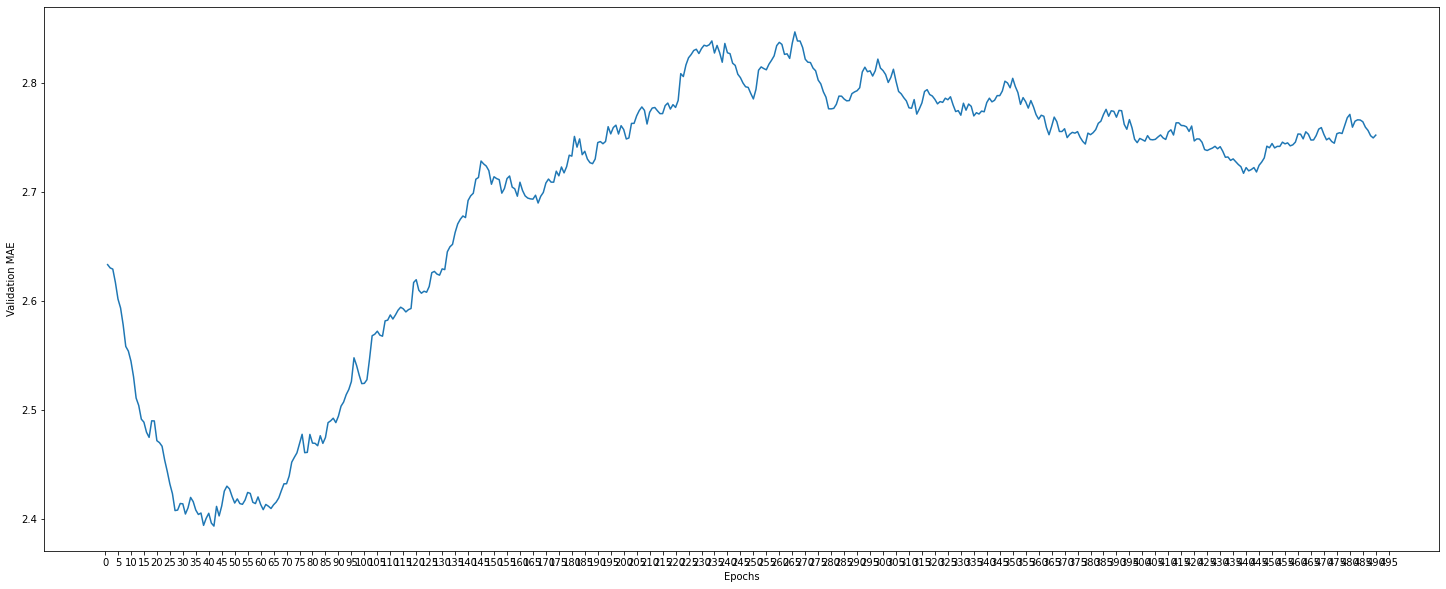

In [53]:
plt.figure(figsize=(25, 10))
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.xticks(np.arange(0,500,5))
plt.show()

이 그래프를 보면 검증MAE가 65번째 에포크 이후에 줄어드는 것을 멈추었다. 이 지점 이후로는 과대적합이 시작된다. <br>
모델의 여러 매개변수에 대한 튜닝(에포크수, 은닉층 크기 등)이 끝나면 테스트 데이터로 성능을 확인한다. 

### 5. 최종 모델 훈련

In [54]:
model = build_model()
model.fit(scaled_train_data, train_targets,
          epochs = 65,
          batch_size = 16,
          verbose = 0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 1ms/step - loss: 5633207.0000 - mae: 2340.4072


In [57]:
test_mae_score

# 2,340달러 정도 차이가 난다.

2340.4072265625